# An example on prototype selection
In this notebook, we show an example of selecting prototypical examples from the source dataset which are representative of the target dataset. We experiment with the popular [digit dataset](https://scikit-learn.org/stable/auto_examples/datasets/plot_digits_last_image.html). Two partitions are randomly created, **src** and **tgt**, which correspond to the source and target sets, respectively. [Our approach](https://link.springer.com/chapter/10.1007/978-3-030-86514-6_33) exploits the optimal tranpot theory to learn prototypes from **src** by matching the prototype distribution with the target **tgt** distribution.

In [ ]:
# install interpret if not already installed

try:
    import interpret
except:
    !pip install --quiet interpret numpy scikit-learn matplotlib

# the kernel might need to be restarted after running this cell

We load the required packages. The package/file specific to the prototype selection algorithm is "SPOTgreedy". 

In [26]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import pairwise_distances
import numpy as np  
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from interpret.utils import SPOT_GreedySubsetSelection # This loads the SPOT prototype selection algorithm.

We now load the digit dataset and create **src** and **tgt** sets by splitting the digit data into 70/30 partitions.

In [27]:
# Load the digits dataset
digits = load_digits()

# Flatten the images
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

# Split data into 70% src and 30% tgt subsets 
X_src, X_tgt, y_src, y_tgt = train_test_split(
    data, digits.target, test_size=0.3, shuffle=False)

Pairwise distances/dissimilarities between the source and target points are required. The optimal transport framework allows the use of any distance/dissimilarity measure. In this example, we use the Euclidean distance metric.

In [28]:
# Compute the Euclidean distances between the X_src (source) and X_tgt (target) points.
C = pairwise_distances(X_src, X_tgt, metric='euclidean');


`targetmarginal` is the empirical distribution over the target points. It is usually taken to be uniform, i.e., every target point is given equal importance. For the experiments, we discuss two settings. In the first setting, we take `targetmarginal` to be uniform. In the second setting, we skew `targetmarginal` against points of a particular class. The experiments show that in both of these settings, the learnt prototypes nicely represent the target distribution `targetmarginal`. 

**Setting 1: target distribution is uniform**

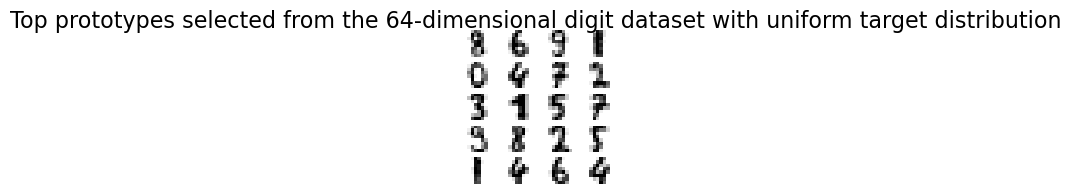

In [29]:
# Define a targetmarginal on the target set
# We define the uniform marginal
targetmarginal = np.ones(C.shape[1])/C.shape[1];


# The number of prototypes to be computed
numprototypes = 20;

# Run SPOTgreedy
# prototypeIndices represent the indices corresponding to the chosen prototypes.
# prototypeWeights represent the weights associated with each of the chosen prototypes. The weights sum to 1. 
[prototypeIndices, prototypeWeights] = SPOT_GreedySubsetSelection(C, targetmarginal, numprototypes);

# Plot the chosen prototypes
fig, axs = plt.subplots(nrows=5, ncols=4, figsize=(2, 2))
for idx, ax in enumerate(axs.ravel()):
    ax.imshow(data[prototypeIndices[idx]].reshape((8, 8)), cmap=plt.cm.binary)
    ax.axis("off")
_ = fig.suptitle("Top prototypes selected from the 64-dimensional digit dataset with uniform target distribution", fontsize=16)

**Setting 2: target distribution is skewed**

In this setting, we skew the examples in **tgt** corresponding to the label `3` by 90%. We expect that a large majority of the learnt prototypes also belong the label `3`. 

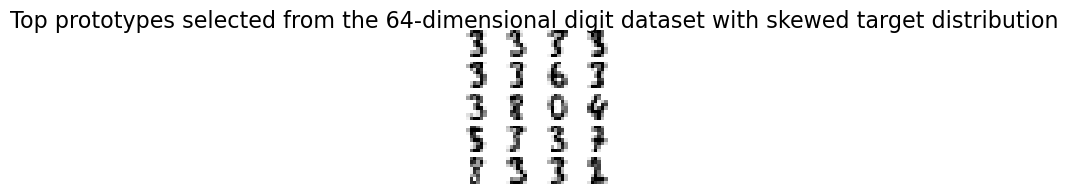

In [30]:
# Skew the target marginal to give weights to specific classes more
result = np.where(y_tgt == 3); # find indices corresponding to label 3.


targetmarginal_skewed = np.ones(C.shape[1]);
targetmarginal_skewed[result[0]] = 90; # Weigh the instances corresponding to label 3 more.
targetmarginal_skewed = targetmarginal_skewed/np.sum(targetmarginal_skewed);

# Run SPOTgreedy
[prototypeIndices_skewed, prototypeWeights_skewed] = SPOT_GreedySubsetSelection(C, targetmarginal_skewed, numprototypes);

# Plot the prototypes selected
fig, axs = plt.subplots(nrows=5, ncols=4, figsize=(2, 2))
for idx, ax in enumerate(axs.ravel()):
    ax.imshow(data[prototypeIndices_skewed[idx]].reshape((8, 8)), cmap=plt.cm.binary)
    ax.axis("off")
_ = fig.suptitle("Top prototypes selected from the 64-dimensional digit dataset with skewed target distribution", fontsize=16)

